## Creating Ancillaries

The [Regional Ancillary Suite](https://code.metoffice.gov.uk/trac/rmed/wiki/suites/RAS) is used to set domains and create ancillary data for regional models.

Suite **u-cy368** has been set up to create ancillaries for our sample domain. Check out the suite with `rosie checkout` and open it in `rose edit`. Make sure to set the SITE to `nci-gadi` in 'General Run Options'.

### Defining Domains

Domains are defined in two layers, regions and resolutions. This allows the domain to be relocatable by just changing the region centre, without having to change the model grid setups.

At this stage we're not worried about which nest is inside which, that will get defined in the Regional Nesting Suite.

Aus2200 domains are named by their grid spacing in ten-thousandths of a degree - `d0198` represents a 0.0198 degree grid spacing in both latitude and longitude.

#### Regions

**Regions** set the primary location of the domain. You can define this either as the domain centre or as the bottom left corner. Regions also control if a rotated grid is being used. Configuration options are prefixed with the region number, e.g. `rg01_name`.

* **name**: A name for this region
* **use_centre**: True if the location is for the region centre, false for the bottom left corner
* **centre**: Region centre
* **rot_grid**: True if using a rotated pole (useful at high latitudes)

When rotated pole is enabled, the grid coordinates will be transformed so that the centre of your domain is at 0N 0E in the new coordinate system. At high latitudes this will give much more evenly spaced grid cells.

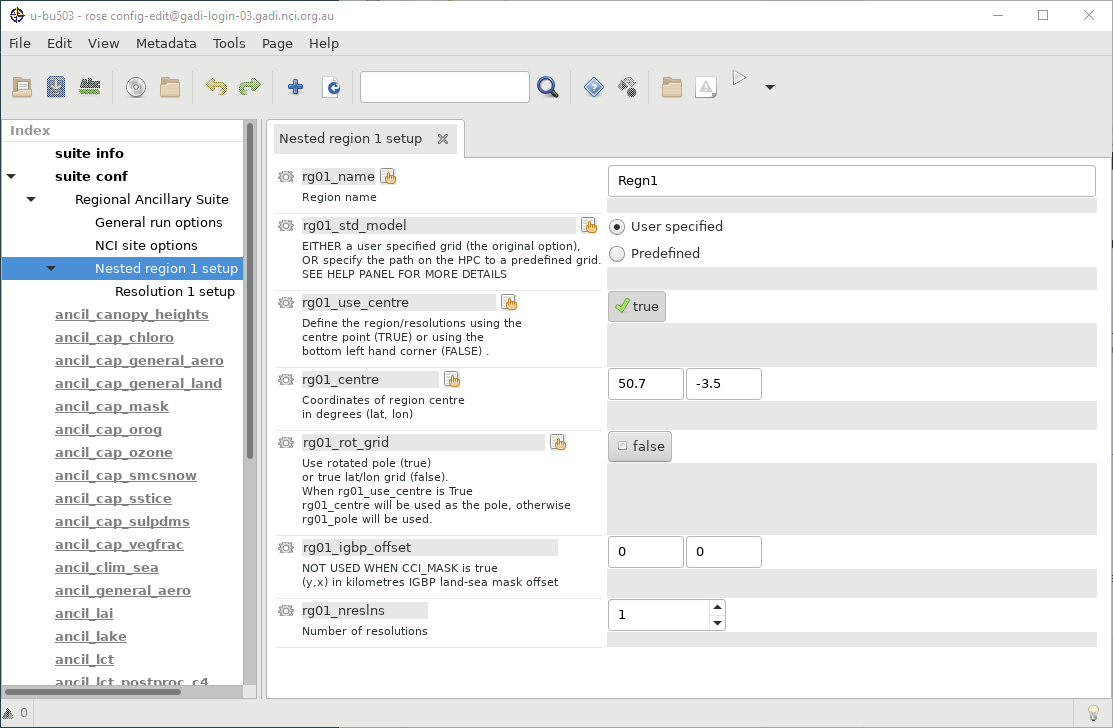

#### Resolutions

**Resolutions** define actual grids, including the grid size and spacing. Configuration options are prefixed with the region and resolution number, e.g. `rg01_rs01_name`.

* **name**: A name for this resolution
* **delta**: Grid spacing in degrees
* **npts**: Grid size
* **offset**: Offset from the region location
* **levset**: Vertical levels - RAL configurations should use L90_40km (90 vertical levels, max height 40 km)

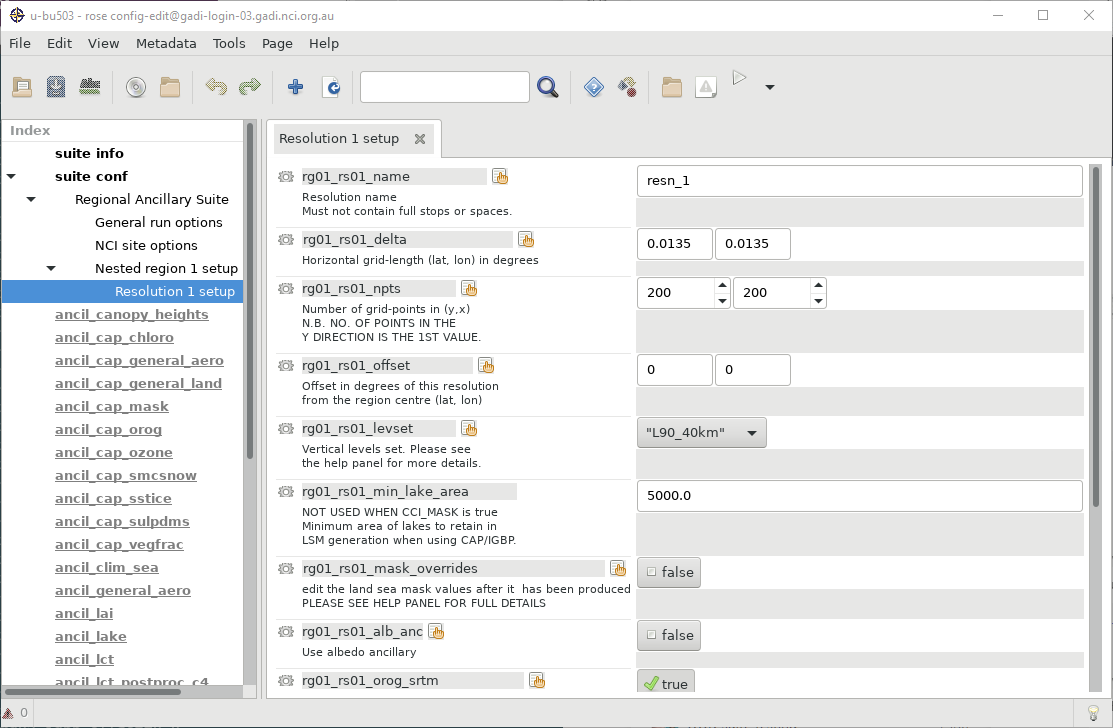

### Ancillary Options

There are a number of options for which ancillary files to create. Which you'll need will depend on the model's science settings. SRTM orography should be enabled when working at km-scale or finer resolutions.

### Exercise

Plan out creating ancillaries for your own domain (max 200x200 grid size)

At the boundary of the regional domain the model is merged with the driving lateral boundary conditions. The driving data always has to be a bit larger than the target domain, you can't for instance have an outer nest domain and an inner nest domain share the same edge.

Boundary data can be saved as a 'frame', where the innermost part of the data is cut out leaving only data around the edge. In this case the frame has to cover from the domain's 'halo' to the domain's 'rim' (both configurable in the model's LBC configuration).

Here's some Python code to plot out the region that may be helpful when planning your domain

In [1]:
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy

def plot_region(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), rim: int=9, halo: T.Tuple[int, int]=(7,7), **kwargs):
    """
    Plots a LAM region, including its rim and halo
    """
    
    draw_box_centre_size(ax, name, centre, res, size, pole, **kwargs)
    
    rim_size = [size[0]-rim*2, size[1]-rim*2]
    draw_box_centre_size(ax, name + '_rim', centre, res, rim_size, pole, ls='--', **kwargs)
    
    halo_size = [size[0]+halo[0]*2, size[1]+halo[1]*2]
    draw_box_centre_size(ax, name + '_halo', centre, res, halo_size, pole, ls=':', **kwargs)
    
def draw_box_centre_size(ax, name: str, centre: T.Tuple[float, float], res: T.Tuple[float, float], size: T.Tuple[int, int], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its centre and size
    """
    size_lon = res[1] * size[1]
    size_lat = res[0] * size[0]

    draw_box_corners(ax, name, corners=[centre[1]-size_lon/2, centre[1]+size_lon/2, centre[0]-size_lat/2, centre[0]+size_lat/2], pole=pole, **kwargs)
    
def draw_box_corners(ax, name: str, corners: T.Tuple[float, float, float, float], pole: T.Tuple[float, float]=(90,180), **kwargs):
    """
    Draws a box given its corners
    """
    x0,x1,y0,y1 = corners
    
    lons = numpy.linspace(x0,x1)
    lats = numpy.linspace(y0,y1)
        
    crs = ccrs.RotatedGeodetic(pole[1], pole[0])
    ax.plot(lons, [y0]*lons.size, transform=crs, **kwargs, label=name) 
    ax.plot(lons, [y1]*lons.size, transform=crs, **kwargs) 
    ax.plot([x0]*lats.size, lats, transform=crs, **kwargs) 
    ax.plot([x1]*lats.size, lats, transform=crs, **kwargs) 

In [2]:
import iris
import iris.plot

frames_se = iris.load_cube('/scratch/hc46/saw562/nri-workshop-tutorial/barra-frames/20200119T1800Z/frame_barra-se', 'air_potential_temperature')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/iris/coords.py:2047: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/iris/coords.py:2047: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


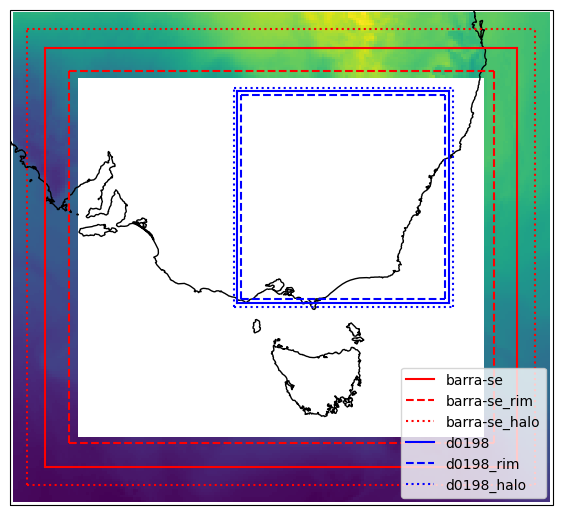

In [3]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.PlateCarree())

iris.plot.pcolormesh(frames_se[0,0,:,], axes=ax)
plot_region(ax, 'barra-se', centre=[-36.96,145.02], res=[0.11, 0.11], size=[160,180], color='r')
plot_region(ax, 'd0198', centre=[-34.43,147.615], res=[0.0198,0.0198], size=[450,450], color='b')

ax.coastlines('10m')
ax.legend(loc='lower right')

## Rotated Poles

At high latitudes a regular lat-lon grid can become very distorted. In this case you can use a rotated pole to get more evenly sized grid cells.

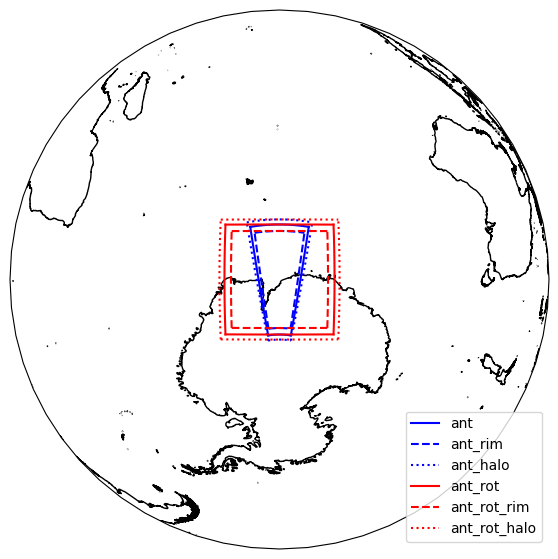

In [4]:
plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.NearsidePerspective(central_latitude=-68, central_longitude=78))

plot_region(ax, 'ant', centre=[-68,78], res=[0.135,0.135], size=[150,150], color='b')
plot_region(ax, 'ant_rot', centre=[0,0], res=[0.135,0.135], size=[150,150], pole=[90+68,180+78], color='r')

ax.set_global()
ax.coastlines('10m')
ax.legend(loc='lower right')